In [1]:
"""
18092022 - 19092022
Бруцкий-Стемпковский

v.02 Частотный анализ текста.

Очистка текста от служебных символов. Подсчёт количества предложения и слов в них с учётом сокращений.
Токенизация по словам с помощью NLTK. Лемманизация с помощью pymorphy2.
Подсчёт частоты встречаемости и представление результатов с помощью NLTK b WordCloud.

Работает довольно быстро. Требует загрузки компонентов библиотек.

Для работы требуется исходный текст в формате ASCII в файле text.txt, Список стоп-слов в файле stop_words.txt
"""

'\n18092022 - 19092022\nБруцкий-Стемпковский\n\nv.02 Частотный анализ текста.\n\nОчистка текста от служебных символов. Подсчёт количества предложения и слов в них с учётом сокращений.\nТокенизация по словам с помощью NLTK. Лемманизация с помощью pymorphy2.\nПодсчёт частоты встречаемости и представление результатов с помощью NLTK b WordCloud.\n\nРаботает довольно быстро. Требует загрузки компонентов библиотек.\n\nДля работы требуется исходный текст в формате ASCII в файле text.txt, Список стоп-слов в файле stop_words.txt\n'

В качестве текста выбрано введение к первому тому "Капитала" К. Маркса. Размер исходного текста превышает 60 000 символов. Написан на русском языке, встречаются слова на латинице. Содержит различные знаки препинания, ссылки в различных скобках, библиотечные шифры, и прочее.

В качестве вспомогательного материала использовал материал из интернета:
1. https://habr.com/ru/post/517410/
2. https://grishaev.me/2012/10/05/1/
3. https://tirinox.ru/levenstein-python/
4. https://pymorphy2.readthedocs.io/en/stable/
5. http://dev.kmint21.info/posts/python-summa/

Импортируем необходимые библиотеки.

In [2]:
import string
import nltk
import pandas as pd
import pymorphy2
import stop_words
import wordcloud

import matplotlib.pyplot as plt
%matplotlib inline

Откроем файл, прочтём его содержимое в переменную text, которая будет содержать текст, закроем файл

In [3]:
file_obj = open("text.txt")
text = file_obj.read()
file_obj.close()

len(text)

64334

Сперва пройдём весь текст и избавимся от большинства знаков препинания, цифр, скобок, знаков табуляции и новой строки. Но так как нам требуется разделить текст на предложения, не будем убирать знаки окончания предложения (точки, знак вопроса, восклицательный знак).

In [4]:
spec_symbol = string.punctuation
spec_symbol = spec_symbol.replace(".", "")
spec_symbol = spec_symbol.replace("!", "")
spec_symbol = spec_symbol.replace("?", "")
spec_symbol += string.digits
spec_symbol += "\n\t\'\"”“–"
symbols_of_end_sentence = ".!?"

spec_symbol

'"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~0123456789\n\t\'"”“–'

Удалим все спецсимволы.

In [5]:
for symbol in spec_symbol:
    text = text.replace(symbol, "\x20")
text = text.replace("...", "\x20")
text = text.lower()

len(text)

64332

Выполним токенизацию текста на предложения с помощью библиотеки NLTK. Подсчитаем количество предложений в словах.

In [6]:
text_list = nltk.tokenize.sent_tokenize(text)
number_of_sentence = len(text_list)
list_of_words_in_sentence = []
for _ in text_list:
    list_of_words_in_sentence.append(len(_.split()))
number_of_sentence, len(list_of_words_in_sentence)

(406, 406)

Создадим ДатаФрейм из предложений.

In [7]:
sentence_data_frame = pd.DataFrame(list_of_words_in_sentence)
sentence_data_frame

,0
0,8
1,10
2,14
3,19
4,23
...,...
401,3
402,2
403,3
404,2


Удалим символы конца строки из текста, выполним токенизацию по словам.

In [8]:
text = text.replace(".", "")
text = text.replace("!", "")
text = text.replace("?", "")
text_list = nltk.tokenize.word_tokenize(text)
len(text_list)

8412

Удалим короткие слова (менее 4-х символов).

In [9]:
text_list = [_ for _ in text_list if len(_) > 3]

len(text_list)

6000

Проведем лемматизацию слов с помощью библиотеки Pymorphy2.

In [10]:
morph = pymorphy2.MorphAnalyzer()
text_list_lemm = []

for i in range(len(text_list)):
    text_list_lemm.append(morph.parse(text_list[i])[0].normal_form)

len(text_list_lemm)

6000

Создадим ДатаФрейм из старого и нового списков.

In [11]:
word_data_frame = pd.DataFrame({"Old_Text": text_list, "Lemm_Text": text_list_lemm})
word_data_frame

,Old_Text,Lemm_Text
0,введение,введение
1,производство,производство
2,потребление,потребление
3,распределение,распределение
4,обмен,обмен
...,...,...
5995,вексельный,вексельный
5996,курс,курс
5997,мировой,мировой
5998,рынок,рынок


Удалим стоп слова. Воспользуемся библиотекой PiPy

In [12]:
stop_words_list = stop_words.get_stop_words('ru')
len(stop_words_list)

421

Ещё один набор стоп-слов...

In [13]:
file_obj = open("stop_words.txt", "r")
russian_stopwords = file_obj.read().split()
file_obj.close()

len(russian_stopwords)

262

In [14]:
stop_words_list = set(stop_words_list + russian_stopwords)

len(stop_words_list)

430

In [15]:
text_list_lemm = [_ for _ in text_list_lemm if not _ in stop_words_list]

len(text_list_lemm)

4765

Выполним частотный анализ. Используем метод из библиотеки nltk.

In [16]:
freq_dist = nltk.probability.FreqDist(text_list_lemm)

freq_dist.most_common(20)

[('производство', 243),
 ('потребление', 108),
 ('распределение', 73),
 ('форма', 70),
 ('отношение', 64),
 ('общество', 60),
 ('продукт', 60),
 ('труд', 56),
 ('например', 48),
 ('предмет', 42),
 ('обмен', 39),
 ('определённый', 37),
 ('выступать', 34),
 ('собственность', 31),
 ('момент', 29),
 ('создавать', 28),
 ('капитал', 28),
 ('категория', 28),
 ('образ', 27),
 ('исторический', 26)]

Построим график самых часто упоминаемых слов.

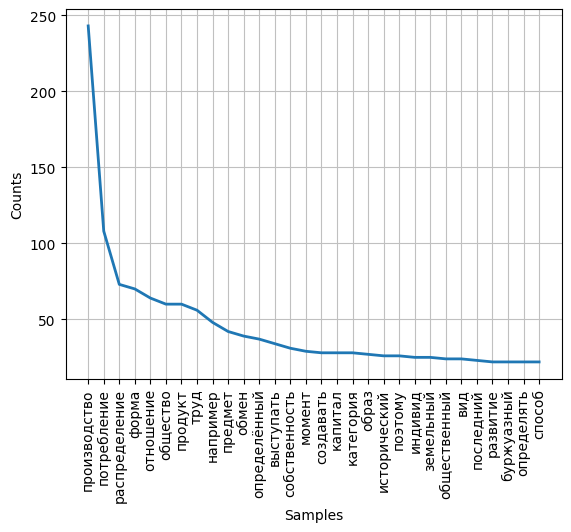

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
freq_dist.plot(30)

Объединим список слов в "сырую" строку для построения облака текста.

In [18]:
text_raw = " ".join(text_list_lemm)

len(text_raw)

46228

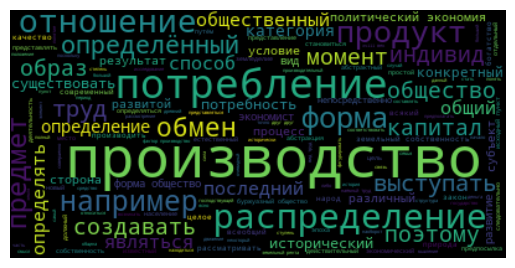

In [19]:
cloud = wordcloud.WordCloud().generate(text_raw)

plt.figure()
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()